## 0. Required Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.stats.mediation as md
import statsmodels.formula.api as smf
import statsmodels.nonparametric.kernel_regression as snkr
import random
import statistics
import semopy
import os
from  pydynpd import regression

# 1. Nonparametric Statistics

### Bootstrap
이때 검정통계량은 $\bar{X}_N$입니다. 다른 검정통계량을 사용하는 경우 `mu`, `muboot`을 구하는 과정을 `mean()` 대신 다른 함수로 대체하면 간편히 수행됩니다.

In [89]:
random.seed(1234)
# data generation
N = 1000
X = np.random.normal(loc = 0.4, scale = 1, size = N)
mu = statistics.mean(X)

# suppose that we have sample X
B = 2000
bootbox = []
for i in range(B):
    Xboot = random.choices(X, k = N) # It should be N!!!!
    muboot = statistics.mean(Xboot)
    bootbox.append(muboot)

<Axes: ylabel='Count'>

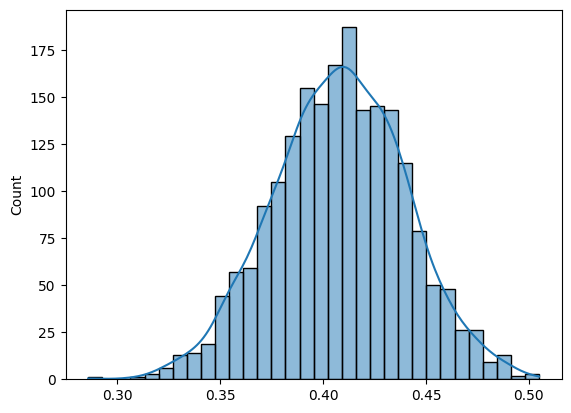

In [90]:
sns.histplot(x = bootbox, kde = True)

In [91]:
# bias estimation
statistics.mean(bootbox) - mu # -0.0004358252475430424
# se estimation
statistics.stdev(bootbox) # 0.03035903933294556
# 정규근사 붓스트랩 신뢰구간
mu - (statistics.mean(bootbox) - mu) + stats.norm.ppf(0.975) * statistics.stdev(bootbox) # 0.49514588527148884
mu - (statistics.mean(bootbox) - mu) - stats.norm.ppf(0.975) * statistics.stdev(bootbox) # 0.3761406378758724
# 붓스트랩 퍼센타일 신뢰구간
np.quantile(bootbox, 0.975) # 0.4995636512795918
np.quantile(bootbox, 0.025) # 0.37295221757557123

0.34391678166466877

### KDE

In [92]:
# data source: https://economics.mit.edu/people/faculty/josh-angrist/angrist-data-archive
data = pd.read_csv("./data/asciiqob.txt", delimiter = "\s+", header = None)
data.columns = ["log_wage", "years_of_schooling", "year_of_birth", "quarter_of_birth", "state_of_birth"]
data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12,30,1,45
1,5.952494,11,30,1,45
2,5.315949,12,30,1,45
3,5.595926,12,30,1,45
4,6.068915,12,30,1,37


<Axes: xlabel='log_wage', ylabel='Density'>

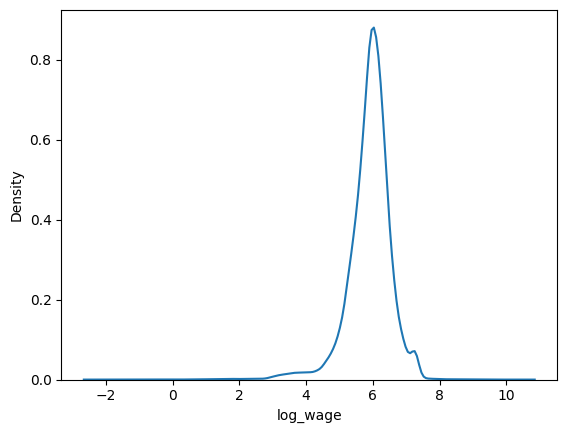

In [93]:
sns.kdeplot(data = data, x = "log_wage", bw_adjust= 2)

<Axes: xlabel='log_wage', ylabel='Density'>

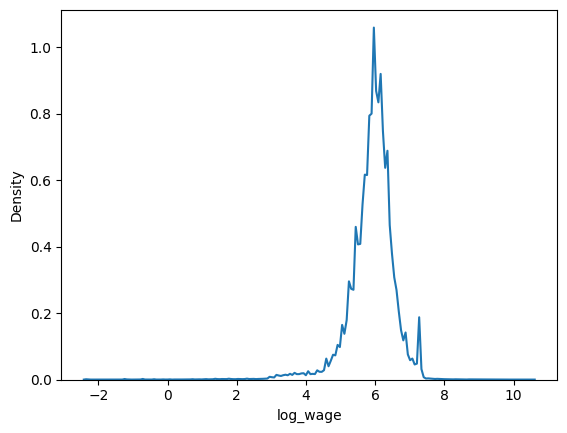

In [94]:
sns.kdeplot(data = data, x = "log_wage", bw_adjust= 0.5)

### Nonparametric Regression

In [271]:
nsw = pd.read_csv("./data/nswdata.txt", delimiter = "\s+")
nsw = nsw[nsw["earnings75"] > 0]
nsw = nsw[nsw["earnings75"] < 10000]
nsw = nsw[nsw["earnings78"] > 0]
nsw = nsw[nsw["earnings78"] < 10000]
nsw = nsw.sort_values(by = ["earnings75"], axis = 0)
nsw.head(5)

,treatment,age,education,black,hispanic,married,nodegree,earnings75,earnings78
258,1.0,17.0,9.0,0.0,1.0,0.0,1.0,74.34345,6210.6700
695,0.0,17.0,11.0,1.0,0.0,0.0,1.0,165.20770,4251.1270
145,1.0,19.0,11.0,1.0,0.0,0.0,1.0,192.79950,661.1924
243,1.0,18.0,11.0,1.0,0.0,0.0,1.0,214.56360,929.8839
627,0.0,18.0,10.0,1.0,0.0,0.0,1.0,240.10670,2891.6680


In [176]:
lcreg = snkr.KernelReg(nsw["earnings75"], nsw["earnings78"], var_type = "c", reg_type = "lc")
llreg = snkr.KernelReg(nsw["earnings75"], nsw["earnings78"], var_type = "c", reg_type = "ll")

In [177]:
y_hat_lc = lcreg.fit(range(10000))[0]
y_hat_ll = llreg.fit(range(10000))[0]

Text(0, 0.5, 'Earnings in 1978')

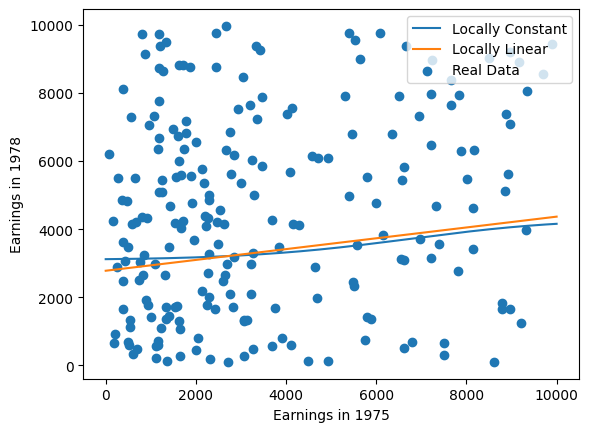

In [178]:
plt.plot(range(10000), y_hat_lc, label = "Locally Constant")
plt.plot(range(10000), y_hat_ll, label = "Locally Linear")
plt.scatter(nsw["earnings75"], nsw["earnings78"], label = "Real Data")
plt.legend()
plt.xlabel("Earnings in 1975")
plt.ylabel("Earnings in 1978")

# 2. Structural Equation Model

In [272]:
nsw.head(5)

,treatment,age,education,black,hispanic,married,nodegree,earnings75,earnings78
258,1.0,17.0,9.0,0.0,1.0,0.0,1.0,74.34345,6210.6700
695,0.0,17.0,11.0,1.0,0.0,0.0,1.0,165.20770,4251.1270
145,1.0,19.0,11.0,1.0,0.0,0.0,1.0,192.79950,661.1924
243,1.0,18.0,11.0,1.0,0.0,0.0,1.0,214.56360,929.8839
627,0.0,18.0,10.0,1.0,0.0,0.0,1.0,240.10670,2891.6680


In [273]:
model = """
# measurement model
ability =~ education + nodegree + earnings75
ethnicity =~ black + hispanic
responsibility =~ age + married
treat =~ treatment
lastearn =~ earnings78

# regressions
treat ~ ability + ethnicity + responsibility
lastearn ~ treat + ability + ethnicity + responsibility

# residual correlations
education ~~ nodegree
black ~~ hispanic
age ~~ married
"""

model = semopy.Model(model)
res = model.fit(nsw)
print(res)

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 0.839
Number of iterations: 60
Params: -0.200 281.748 -1.400 0.008 -0.014 -0.104 -0.004 -0.005 -0.059 -0.007 -0.062 -0.095 0.662 -0.040 0.145 0.508 22.259 1.539 0.066 3588012.185 4056973.028 0.048 0.029 0.050 0.116 0.102 7.359 0.928 0.163 0.091 0.155


In [274]:
ins = model.inspect()
print(ins)

              lval  op            rval      Estimate               Std. Err  \
0            treat   ~         ability -1.391846e-02           25966.282634   
1            treat   ~       ethnicity -1.036267e-01          373379.523196   
2            treat   ~  responsibility -3.891445e-03           48863.240621   
3         lastearn   ~           treat -5.072316e-03          244791.915317   
4         lastearn   ~         ability -5.903699e-02          373801.962339   
5         lastearn   ~       ethnicity -6.548244e-03         2107855.996165   
6         lastearn   ~  responsibility -6.234037e-02           776848.30571   
7        education   ~         ability  1.000000e+00                      -   
8         nodegree   ~         ability -2.000663e-01               0.055269   
9       earnings75   ~         ability  2.817477e+02             427.674026   
10           black   ~       ethnicity  1.000000e+00                      -   
11        hispanic   ~       ethnicity -1.400142e+00

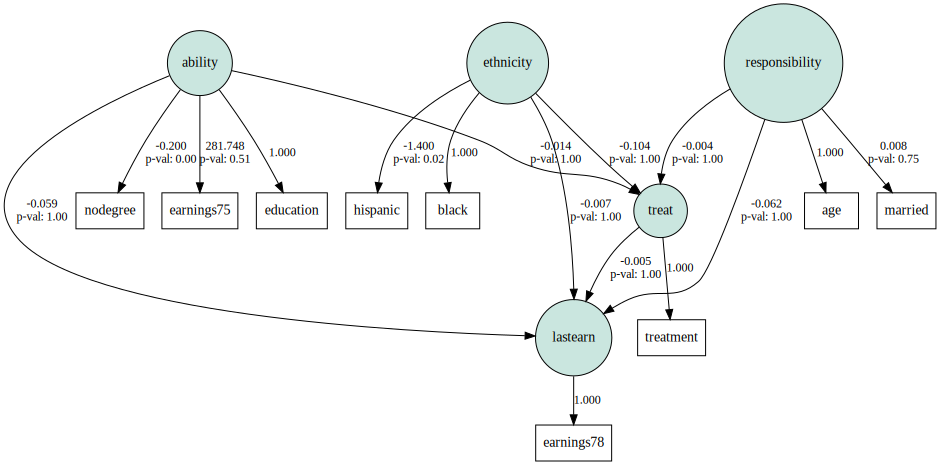

In [275]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
semopy.semplot(model, "sem.png")

# 3. Moderation and Mediation

In [276]:
# moderation
smf.ols(formula = 'earnings78 ~ earnings75*treatment', data = nsw).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             earnings78   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.287
Date:                Mon, 06 May 2024   Prob (F-statistic):             0.0797
Time:                        23:13:05   Log-Likelihood:                -2011.9
No. Observations:                 215   AIC:                             4032.
Df Residuals:                     211   BIC:                             4045.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3991.4077    417.401      9.563      0.000    3168.598    4814.218
earnings75               0.1798      0.094      1.919      0.056      -0.005       0.364
treatment             -310.9336    642.226     -0.484      0.629   -1576.934     955.067
earnings75:treatment     0.0003      0.147      0.002      0.998      -0.289       0.289
==============================================================================
Omnibus:                       35.013   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.758
Skew:                           0.181   Prob(JB):                      0.00760
Kurtosis:                       2.021   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [282]:
# mediation
# treatment: mediator, earnings75: true risk factor
outcome_model = smf.ols("earnings78 ~ age*earnings75 + treatment", data = nsw)
mediator_model = smf.ols("treatment ~ age*earnings75", data = nsw)
med = md.Mediation(
    outcome_model, mediator_model, "earnings75", mediator = "treatment", moderators = {"age" : 20}
).fit()

In [283]:
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-0.849663,-51.803984,49.581695,0.95
ACME (treated),-0.849663,-51.803984,49.581695,0.95
ADE (control),0.226343,0.048697,0.407835,0.01
ADE (treated),0.226343,0.048697,0.407835,0.01
Total effect,-0.623321,-51.521961,49.687171,0.99
Prop. mediated (control),1.001686,0.337194,1.597171,0.04
Prop. mediated (treated),1.001686,0.337194,1.597171,0.04
ACME (average),-0.849663,-51.803984,49.581695,0.95
ADE (average),0.226343,0.048697,0.407835,0.01
Prop. mediated (average),1.001686,0.337194,1.597171,0.04


- `ACME`: Average Causal Mediation Effect (평균 매개효과, 간접효과)
- `ADE`: Average Direct Effect (평균 직접효과)
- `Total effect`: 총효과
- `Prop.mediated`: 전체 효과 중 mediation에 의해 설명되는 비율

# 4. DiD

도저히 못 만들겠습니다... 이번에 너무 예시로 만들 게 많아요 ㅠㅠ 좋은 한글 자료를 굳이 복사해서 다시 하지는 않겠습니다. 아래 페이지 참고해 주세요.
- https://causalinferencelab.github.io/Causal-Inference-with-Python/13-Difference-in-Differences.html

# 5. SC
동일합니다. 아래 페이지 참고해 주세요.
- https://causalinferencelab.github.io/Causal-Inference-with-Python/15-Synthetic-Control.html

# 6. RDD
아래 페이지 참고해 주세요.
- https://causalinferencelab.github.io/Causal-Inference-with-Python/16-Regression-Discontinuity-Design.html

# 7. Fixed Effects Model
사실 그냥 리그레션과 거의 유사합니다. 개체/시간 더미만 잘 넣어준다고 생각하세요.
- https://causalinferencelab.github.io/Causal-Inference-with-Python/14-Panel-Data-and-Fixed-Effects.html

# 8. Dynamic Effects Model
 `pydynpd` 패키지를 사용합니다.
 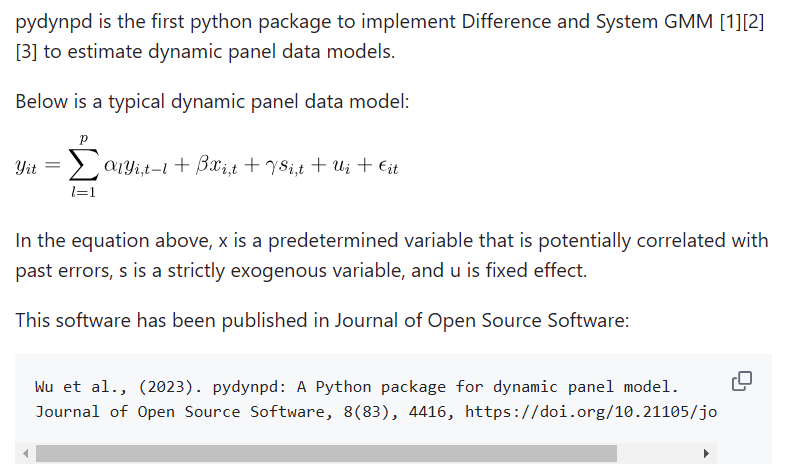

In [11]:
df = pd.read_csv("./data/week5.csv", index_col=0)
df.head(5) # ind: individual num, emp: employment, cap: capital
# n, w, k: ln of emp, wage, and cap... 
# other columns are lagged variables or dummy varables
# you should transform your data like this!

,c1,ind,year,emp,wage,cap,indoutpt,n,w,k,...,ysL2,yr1976,yr1977,yr1978,yr1979,yr1980,yr1981,yr1982,yr1983,yr1984
1,1-1,7,1977,5.041,13.1516,0.5894,95.707199,1.617604,2.576543,-0.528650,...,NaN,0,1,0,0,0,0,0,0,0
2,2-1,7,1978,5.600,12.3018,0.6318,97.356903,1.722767,2.509746,-0.459182,...,NaN,0,0,1,0,0,0,0,0,0
3,3-1,7,1979,5.015,12.8395,0.6771,99.608299,1.612433,2.552526,-0.389936,...,4.561294,0,0,0,1,0,0,0,0,0
4,4-1,7,1980,4.715,13.8039,0.6171,100.550102,1.550749,2.624951,-0.482724,...,4.578383,0,0,0,0,1,0,0,0,0
5,5-1,7,1981,4.093,14.2897,0.5076,99.558098,1.409278,2.659539,-0.678062,...,4.601245,0,0,0,0,0,1,0,0,0


In [12]:
# https://github.com/dazhwu/pydynpd/blob/main/vignettes/Tutorial.ipynb 참고하여 커맨드 작성
# each part is divided by |
# part 1: dependent variables
# part 2: how instruments are created
# part 3: settings for GMM
# 만약 이를 사용하시려 한다면 공부하시고 사용하시면 되겠습니다.
# 저도 이번에 처음 본 패키지라... 하나도 모르겠어요 ㅜㅡㅜ
command_str='n L(1:2).n w k  | gmm(n, 2:4) gmm(w, 1:3)  iv(k) | timedumm  nolevel'
mydpd = regression.abond(command_str, df, ['id', 'year'])

 Dynamic panel-data estimation, two-step difference GMM
 Group variable: id                               Number of obs = 611     
 Time variable: year                              Min obs per group: 4    
 Number of instruments = 42                       Max obs per group: 6    
 Number of groups = 140                           Avg obs per group: 4.36 
+-----------+------------+---------------------+------------+-----------+-----+
|     n     |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+-----------+------------+---------------------+------------+-----------+-----+
|    L1.n   | 0.2710675  |      0.1382542      | 1.9606462  | 0.0499203 |  *  |
|    L2.n   | -0.0233928 |      0.0419665      | -0.5574151 | 0.5772439 |     |
|     w     | -0.5668527 |      0.2092231      | -2.7093219 | 0.0067421 |  ** |
|     k     | 0.3613939  |      0.0662624      | 5.4539824  | 0.0000000 | *** |
| year_1979 | 0.0011898  |      0.0092322      | 0.1288765  | 0.8974554 |     |
| ye